In [ ]:
pip install numpy pandas matplotlib seaborn librosa scikit-learn tensorflow keras


# Pre-processing

In [ ]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
from concurrent.futures import ProcessPoolExecutor, as_completed

def extract_mel_spectrogram(file_path, n_mels=128):
    y, sr = librosa.load(file_path, sr=None)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    S_DB = librosa.power_to_db(S, ref=np.max)
    return S_DB

def save_spectrogram_image(spectrogram, save_path):
    plt.figure(figsize=(10, 4))
    plt.imshow(spectrogram, aspect='auto', origin='lower', cmap='viridis')
    plt.axis('off')
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.close()

def process_audio_file(file_path, output_folder):
    if file_path.endswith('.wav'):
        try:
            spectrogram = extract_mel_spectrogram(file_path)
            save_path = os.path.join(output_folder, os.path.basename(file_path).replace('.wav', '.png'))
            save_spectrogram_image(spectrogram, save_path)
        except Exception as e:
            print(f"Error processing {file_path}: {e}")

dataset_dir = 'dataset'
output_dir = 'spectrograms'

# Ensure output directories exist
os.makedirs(output_dir, exist_ok=True)

for label in ['real', 'fake']:
    input_folder = os.path.join(dataset_dir, label)
    output_folder = os.path.join(output_dir, label)
    os.makedirs(output_folder, exist_ok=True)
    
    if not os.path.exists(input_folder):
        raise FileNotFoundError(f"The directory {input_folder} does not exist. Please check the path.")
    
    # Get list of all audio files
    audio_files = [os.path.join(input_folder, f) for f in os.listdir(input_folder) if f.endswith('.wav')]
    
    # Use ProcessPoolExecutor to process files in parallel
    with ProcessPoolExecutor() as executor:
        futures = [executor.submit(process_audio_file, file_path, output_folder) for file_path in audio_files]
        
        for future in as_completed(futures):
            try:
                future.result()
            except Exception as exc:
                print(f"Generated an exception: {exc}")


# Model Preparation

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(validation_split=0.2, rescale=1./255)

train_gen = datagen.flow_from_directory(
    'spectrograms',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    'spectrograms',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

Found 30 images belonging to 2 classes.
Found 6 images belonging to 2 classes.


In [6]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load ResNet-50 model without the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10
)

Epoch 1/10
1/1 [==============================] - 20s 20s/step - loss: 1.0415 - accuracy: 0.4000 - val_loss: 1.8842 - val_accuracy: 0.8333
Epoch 2/10
1/1 [==============================] - 6s 6s/step - loss: 2.4895 - accuracy: 0.7667 - val_loss: 2.0404 - val_accuracy: 0.8333
Epoch 3/10
1/1 [==============================] - 6s 6s/step - loss: 2.9077 - accuracy: 0.7667 - val_loss: 1.6548 - val_accuracy: 0.8333
Epoch 4/10
1/1 [==============================] - 6s 6s/step - loss: 2.3565 - accuracy: 0.7667 - val_loss: 1.0189 - val_accuracy: 0.8333
Epoch 5/10
1/1 [==============================] - 6s 6s/step - loss: 1.3448 - accuracy: 0.7667 - val_loss: 0.4553 - val_accuracy: 0.8333
Epoch 6/10
1/1 [==============================] - 6s 6s/step - loss: 0.6379 - accuracy: 0.7333 - val_loss: 1.3736 - val_accuracy: 0.1667
Epoch 7/10
1/1 [==============================] - 6s 6s/step - loss: 1.2607 - accuracy: 0.3000 - val_loss: 1.2425 - val_accuracy: 0.1667
Epoch 8/10
1/1 [=======================

# Evaluation

1/1 [==============================] - 1s 928ms/step - loss: 0.6044 - accuracy: 0.8333
Validation accuracy: 83.33%
1/1 [==============================] - 3s 3s/step


C:\Users\yadav\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

        fake       0.83      1.00      0.91         5
        real       0.00      0.00      0.00         1

    accuracy                           0.83         6
   macro avg       0.42      0.50      0.45         6
weighted avg       0.69      0.83      0.76         6



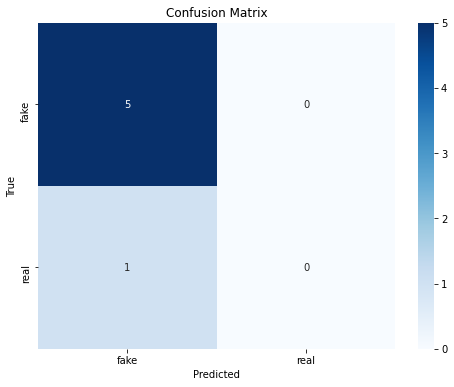

In [7]:
# Evaluate the model on the validation set
val_gen.reset()
val_loss, val_accuracy = model.evaluate(val_gen)
print(f'Validation accuracy: {val_accuracy*100:.2f}%')

# Predict on validation set
y_pred_prob = model.predict(val_gen)
y_pred = (y_pred_prob > 0.5).astype(int)
y_true = val_gen.classes

# Classification report
from sklearn.metrics import classification_report, confusion_matrix
report = classification_report(y_true, y_pred, target_names=val_gen.class_indices.keys())
print(report)

# Confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=val_gen.class_indices.keys(), yticklabels=val_gen.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
